# Model performance evaluation
## Context and objectives
Since the start of this project, I had the chance to present it twice to industry experts. From both presentations I received a number of feedback points related to the performance of the system and its viability in a real-case scenario. In particular, the comments were related to the following points:
1. The dataset is heavily imbalanced (193 shooters against 1000 negatively classified individuals in the best case and 300M+ individuals in the US population)
2. Because the risk associated with a false negative and the ethics of a false positive, the precision and recall may be carefully balanced

Since then, I have also better understood different performance metrics such as the F1-score and the ROC Curve and AUC. I also want to spend more time on looking at the classification threshold.

## Methodology
In this notebook, I spend more time evaluating each of the models I have developped. I first start with the Logistic Regression which is recommended as a first model thanks to its balance of performance and interpretability.

### Preparation
For this model, the following steps are used for all iterations:
1. Import and split the data
2. Scale the data

### Metrics
- accuracy
- precision-recall curve
- f1 curve
- roc curve and auc

In [1]:
# Ignore all warnings
from warnings import simplefilter
simplefilter(action='ignore')

# Data and files manipulation
import numpy as np
import pandas as pd
from pathlib import Path
import pickle

# Visualisation
from matplotlib import pyplot as plt
import seaborn as sns

# Import dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import imblearn.over_sampling as OS

# Import the models from SKLearn (Model 1 through Model 6)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# Import the modules to evaluate the models
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, precision_recall_curve
from sklearn.metrics import roc_curve, auc

### Functions

In [2]:
def transform_gender_col(df):
    # Change gender column to male/other (male = yes, other = no)
    df.loc[df['Gender'] != 'Male', 'Gender'] = 'No'
    df.loc[df['Gender'] == 'Male', 'Gender'] = 'Yes'

    # Rename column from 'Gender' to 'Male'
    return df.rename(columns={'Gender': 'Male'})

def transform_autism_col(df):
    # Change autism column values to Yes and No
    df.loc[df['Autism'] != 'No evidence', 'Autism'] = 'Yes'
    df.loc[df['Autism'] == 'No evidence', 'Autism'] = 'No'
    return df

def transform_employed_col(df):
    # Change employed column values to Yes and No
    df.loc[df['Employed'] != 'Working', 'Employed'] = 'No'
    df.loc[df['Employed'] == 'Working', 'Employed'] = 'Yes'
    return df

In [3]:
def one_hot_encoding(df):
    # Get all the features with only two unique values in a list
    mask = df.nunique()==2
    feature_with_2_values = list(df.nunique()[mask].index)

    # Change all the 2-value features to binary columns (1 = 'Yes', 0 = 'No')
    for feat in feature_with_2_values:
        df[feat] = [1 if c=='Yes' else 0 for c in df[feat]]

    return df

In [4]:
def encode_categorical_features(df):
    categorical_features = list(df.dtypes[df.dtypes == 'object'].index)
    numeric_features = list(df.dtypes[df.dtypes != 'object'].index)

    if len(categorical_features) > 0:
        # Get dummies for categorical features
        dummies_df = pd.get_dummies(df[categorical_features])

        # Recombine all features
        return pd.concat([df[numeric_features], dummies_df], axis=1)
    else:
        return df

In [5]:
def scale_data(X_train, X_test, scale):
    if scale:
        # Creating StandardScaler instance
        scaler = StandardScaler()

        # Fitting Standard Scaller
        X_scaler = scaler.fit(X_train)

        # Scaling data
        X_train = X_scaler.transform(X_train)
        X_test = X_scaler.transform(X_test)
    
    return X_train, X_test


#### Functions for data visualisation

In [6]:
# Define plot parameters
main_color = '#969696'
highlight_color = '#04bfb3'
default_figsize = (10,6)

In [7]:
def show_confusion_matrix(matrix, title, save=False):
    fig, ax = plt.subplots()

    sns.heatmap(
        matrix,
        annot=True,
        fmt='g',
        square=True,
        xticklabels=['0', '1'],
        yticklabels=['0', '1'],
        cmap=sns.color_palette(f"light:{highlight_color}", as_cmap=True)
    ).set(
        xlabel='ACTUAL',
        ylabel='PREDICTED',
        title=title
    )

    if save:
        plt.savefig(f'{title}.png')
    
    plt.show()

In [8]:
def model_performance_metrics(y_test, y_proba, y_pred, model_name='Unnamed'):
    
    # Calculate accuraccy, precision, recall and F1-score
    accuracy = accuracy_score(y_test, y_pred)*100
    precision = precision_score(y_test, y_pred)*100
    recall = recall_score(y_test, y_pred)*100
    f1 = f1_score(y_test, y_pred)*100

    # Get P-R curve parameters (numpy arrays)
    p_curve, r_curve, t_curve = precision_recall_curve(y_test, y_proba)
    f1_scores = [f1_score(y_test, (y_proba >= t)) for t in t_curve]

    # ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    auc_score = auc(fpr, tpr)*100

    # ROC curve parameters
    roc_param = {
        'fpr': fpr,
        'tpr': tpr,
        'thr': thresholds
    }

    # Precision-Recall curve parameters
    pr_curve = {
        'p_curve': p_curve,
        'r_curve': r_curve,
        't_curve': t_curve,
        'f1_curve': f1_scores
    }

    # Group all metrics
    metrics = {
        'model': model_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'auc_score': auc_score
    }

    return metrics, pr_curve, roc_param

In [9]:
def plot_prcurve(pr_curve, model_name='Unnamed'):
    p_curve, r_curve, t_curve, f1_scores = pr_curve['p_curve'], pr_curve['r_curve'], pr_curve['t_curve'], pr_curve['f1_curve']

    # Plot curve
    fig, ax = plt.subplots(figsize=(10,6))
    
    ax.plot(t_curve, p_curve[:-1], label = 'Precision', ls='--', c=main_color)
    ax.plot(t_curve, r_curve[:-1], label = 'Recall', c=main_color)
    ax.plot(t_curve, f1_scores, label='F1 Curve', c=highlight_color)

    ax.set_xlabel('Prediction Threshold')
    ax.set_ylabel('Scores')
    
    ax.legend()
    
    fig.suptitle('Precision-Recall Curve')
    ax.set_title(f'Model: {model_name}')

    plt.show()

In [10]:
def plot_roc_curve(roc_param, metrics, model_name='Unnamed'):
    fpr, tpr, thresholds, auc_score = roc_param['fpr'], roc_param['tpr'], roc_param['thr'], metrics['auc_score']

    # Plot the ROC Curve
    fig, ax = plt.subplots(figsize=(10,6))
    
    ax.plot(fpr, tpr, label = f'Model (AUC = {auc_score/100:.2f})', c=highlight_color)
    ax.plot([0,1], [0,1], 'k--', label = 'Random Guess (AUC = 0.5)', c=main_color)

    # Formatting
    ax.set_xlabel('False Postive Rate')
    ax.set_ylabel('True Postive Rate')

    fig.suptitle('ROC Curve')
    ax.set_title(f'Model: {model_name}')
    
    ax.legend()
    plt.show()

In [11]:
def plot_feature_importances(model, features):
    # Retrieve feature importances
    f_importance = model.feature_importances_ # Works for trees

    feature_importances = pd.DataFrame({
        'Features': features,
        'Importance': f_importance
    }).sort_values('Importance', ascending=False)

    non_zero_importances = feature_importances.loc[feature_importances['Importance']>0,:]

    # Plot
    fig, ax = plt.subplots(figsize=(10,8))

    sns.despine()

    sns.barplot(
        non_zero_importances,
        x = 'Importance',
        y = 'Features',
        color=main_color
    )

    ax.set_ylabel('')

    ax.set_title('Feature Importances (non-zero features only)')

    plt.show()

## Import and prepare data

In [12]:
# Import Shooter data
shooters_df = pd.read_csv(Path('model_blackbox_shooters_v8.csv'))
shooters_df = transform_autism_col(shooters_df)

# Import General Population data and transform features to match shooter DataFrame
genpop_df = pd.read_csv(Path('model_blackbox_genpop.csv'))
genpop_df = transform_gender_col(genpop_df)
genpop_df = transform_autism_col(genpop_df)
genpop_df = transform_employed_col(genpop_df)

In [13]:
# Create one table with all data
all_data = pd.concat([shooters_df, genpop_df], axis=0)

## Feature Engineering

### Separate the data into labels and features

In [14]:
# Separate the y variable, the labels
y = all_data['Classification']

# Separate the X variable, the features
X = all_data.drop(columns='Classification')

In [15]:
X = one_hot_encoding(X)
X = encode_categorical_features(X)

## Model preparation

### Model 1: Classification Tree
The goal for this model is to establish a baseline and perform an analysis of the features importance.

,model,accuracy,precision,recall,f1_score,auc_score
0,Classification Tree,99.117647,78.378378,74.358974,76.315789,95.887313


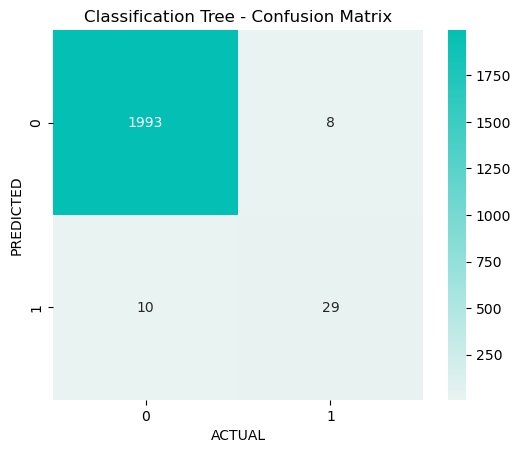

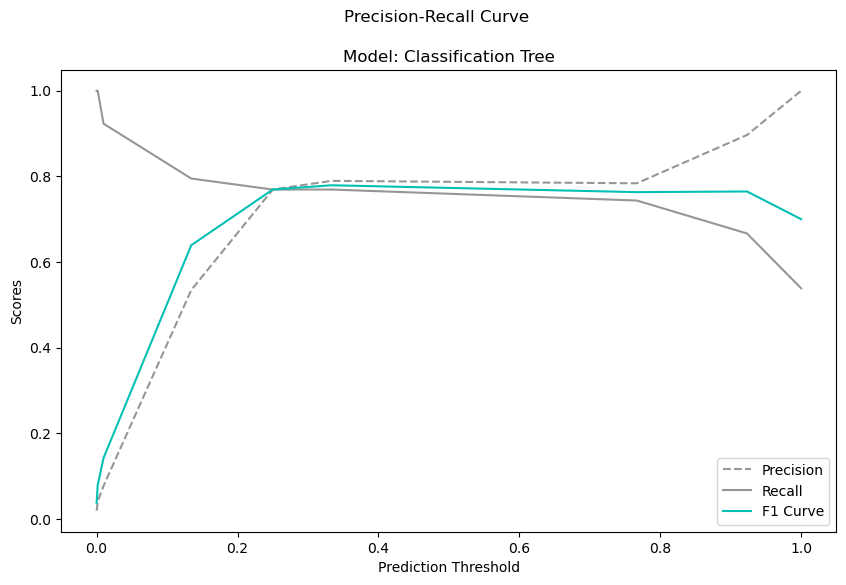

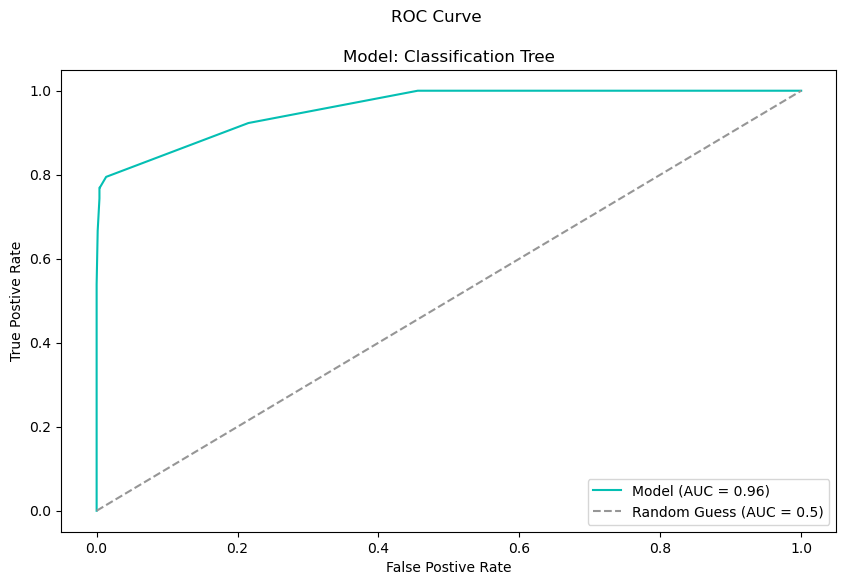

In [17]:
# Split the data using train_test_split
# Assign a random_state of 1 to the function
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=1,stratify=y, test_size=0.2)
X_train, X_test = scale_data(X_train, X_test, False)

# Prepare and fit model
model_1 = DecisionTreeClassifier(max_depth=8).fit(X_train, y_train)
model_1_name = 'Classification Tree'

# Get predictions and probabilities
y_pred_1 = model_1.predict(X_test)
y_proba_1 = model_1.predict_proba(X_test)[:,1]

# Get model performance metrix
metrics_1, pr_curve_1, roc_param_1 = model_performance_metrics(y_test, y_proba_1, y_pred_1, model_1_name)
display(pd.DataFrame([metrics_1]))

# Compute and display confusion matrix
model_1_cm = confusion_matrix(y_test, y_pred_1)
show_confusion_matrix(model_1_cm, f'{model_1_name} - Confusion Matrix')

# Plot Precision-Recall Curve
plot_prcurve(pr_curve_1, model_1_name)

# ROC Curve
plot_roc_curve(roc_param_1, metrics_1, model_1_name)


### Feature importance (from classification tree)
When looking at the importance of the different features in this first model, it becomes clear that an 'Unknown' socio-economic status (SES) or employment type (Work) will have the greatere impact. This is in particular true for the SES=Unknown category which is a dominant feature.

When looking more into the reason behind this, it becomes clear that these 'Unknown' categories are unique to the shooters data and not present in the general population data. This will give a false indication to the model that these categories are a good indicator for the classification.

Different approaches can be taken to handle this problem:
1. Remove the features altogether and let the model work with the remaining categories.
2. Remove the rows where the feature appear. This will however significantly reduce the training dataset, which is already small, and leave uncertainty on the test dataset as these values cannot easily be imputed due to the proportion of missing data.
3. Finally, missing values could randomly be introduced into the general population dataset. This may however create artificial relationships between features as the mechanism behind these missing data are not known.

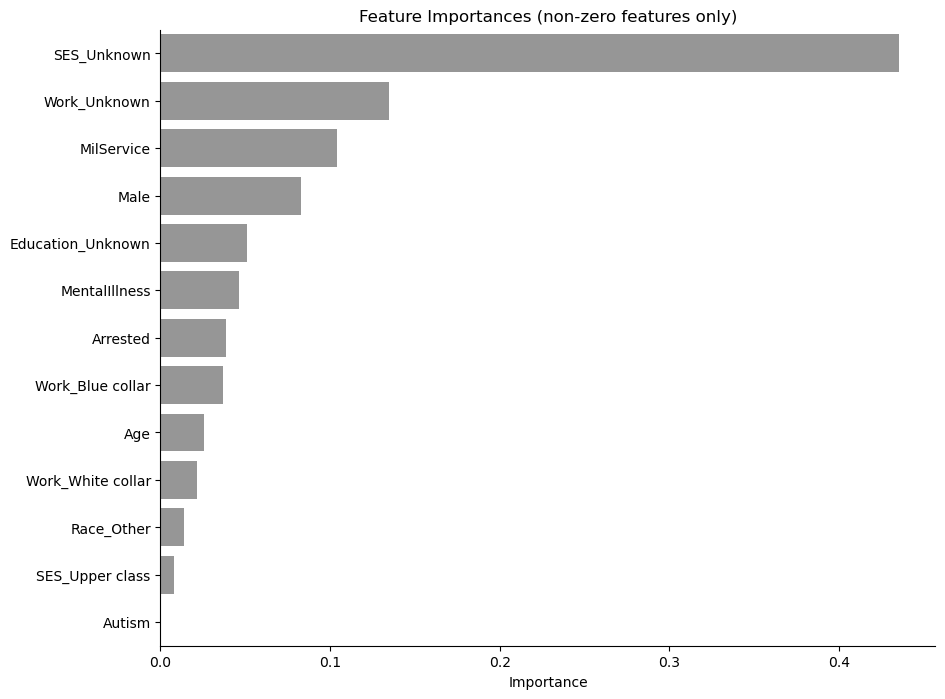

In [18]:
plot_feature_importances(model_1, X.columns)

In [19]:
shooters_df['SES'].value_counts()

Unknown         63
Middle class    62
Lower class     53
Upper class     19
Name: SES, dtype: int64

In [20]:
genpop_df['SES'].value_counts()

Middle class    4316
Lower class     2987
Upper class     2697
Name: SES, dtype: int64

In [21]:
shooters_df['Work'].value_counts()

Blue collar     125
Unknown          32
In between       23
White collar     17
Name: Work, dtype: int64

In [22]:
genpop_df['Work'].value_counts()

Blue collar     3767
White collar    3269
In between      2964
Name: Work, dtype: int64

### Remove 'Unknown' categories from SES and Work features
To address the problem of the dominance of shooter-specific values, we remove the `SES_Unknown` and `Work_Unknown` columns from the dataset before reapplying the model.

In [23]:
# Remove categrories that are unique to the shooter dataset and not present in the general population dataset
X_2 = X.drop(columns=['Work_Unknown', 'SES_Unknown', 'Education_Unknown', 'Male'])

In [24]:
# Split the data using train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_2,y,random_state=1,stratify=y, test_size=0.2)
X_train, X_test = scale_data(X_train, X_test, False)

In [25]:
# Declare model
model_2 = DecisionTreeClassifier(max_depth=8)
model_2_name = 'Classification Tree'

,model,accuracy,precision,recall,f1_score,auc_score
0,Classification Tree,98.872549,78.571429,56.410256,65.671642,87.275593


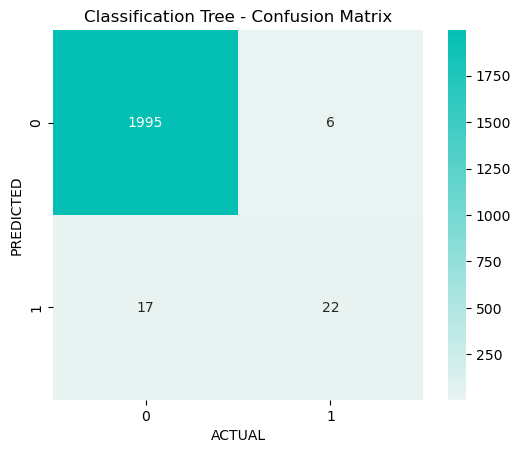

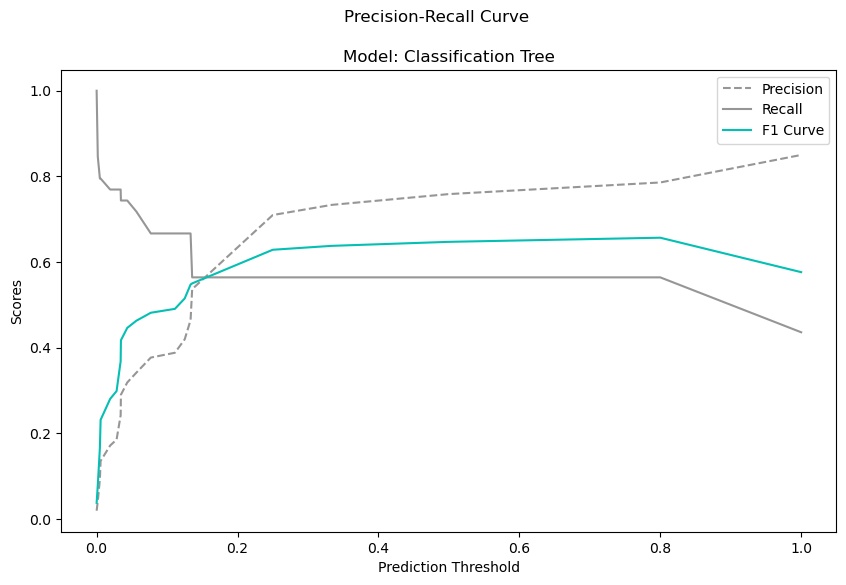

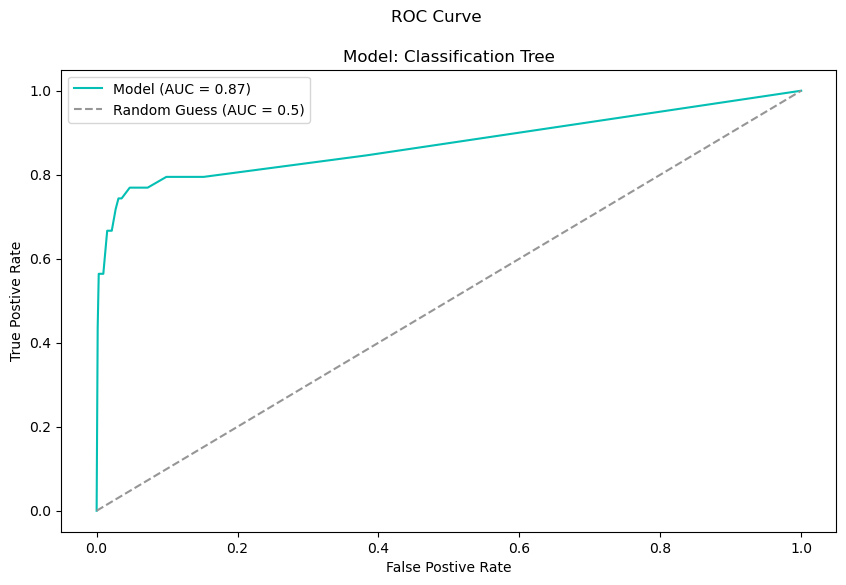

In [26]:
# Fit model
model_2 = model_2.fit(X_train, y_train)

# Get predictions and probabilities
y_pred_2 = model_2.predict(X_test)
y_proba_2 = model_2.predict_proba(X_test)[:,1]

# Get model performance metrics
metrics_2, pr_curve_2, roc_param_2 = model_performance_metrics(y_test, y_proba_2, y_pred_2, model_2_name)

# Display model's main metrics
display(pd.DataFrame([metrics_2]))

# Compute and display confusion matrix
model_2_cm = confusion_matrix(y_test, y_pred_2)
show_confusion_matrix(model_2_cm, f'{model_2_name} - Confusion Matrix')

# Plot Precision-Recall Curve
plot_prcurve(pr_curve_2, model_2_name)

# ROC Curve
plot_roc_curve(roc_param_2, metrics_2, model_2_name)


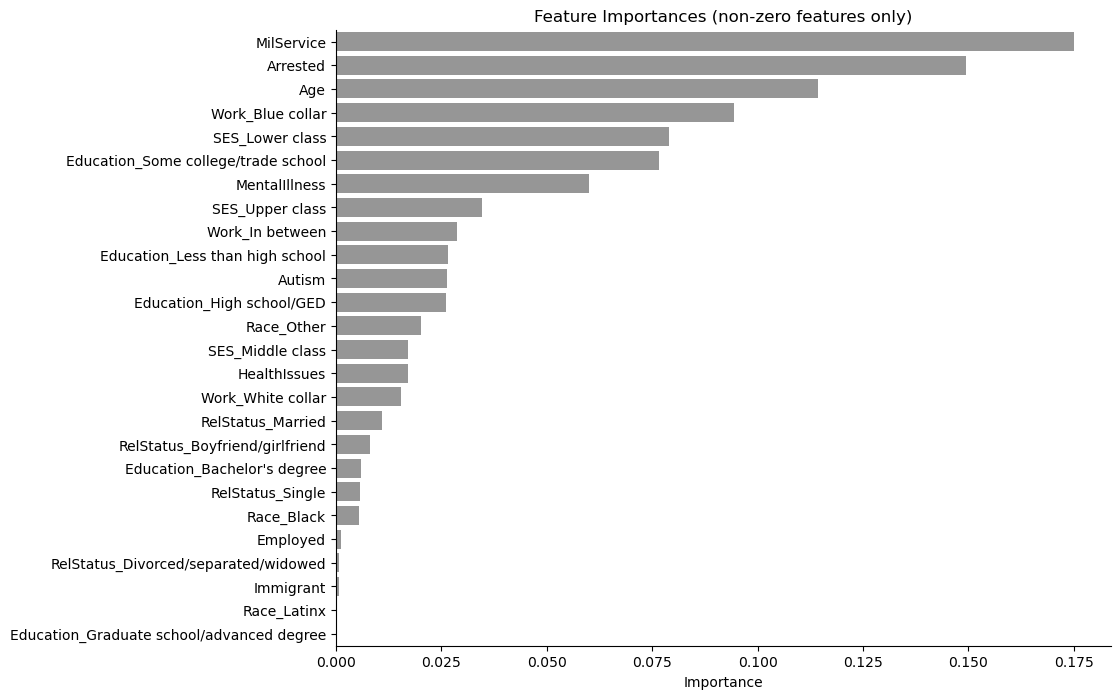

In [27]:
plot_feature_importances(model_2, X_2.columns)

## Comparison based on features used
By removing the important features that are unique to the shooters data but absent from the general population, the performance of the model drops in all metrics. It however remains acceptable, especially when compared to a random classifier (AUC = 87%). It is also important to remember that this is only a preliminary model that has not been tuned. These results are therefore encouraging and constitute a sane baseline to improve on.

In [28]:
metrics_overview = pd.DataFrame([metrics_1, metrics_2])

# Rename models for clarity
metrics_overview.loc[0, 'model'] = 'Class. Tree (all features)'
metrics_overview.loc[1, 'model'] = 'Class. Tree (limited features)'

metrics_overview

,model,accuracy,precision,recall,f1_score,auc_score
0,Class. Tree (all features),99.117647,78.378378,74.358974,76.315789,95.887313
1,Class. Tree (limited features),98.872549,78.571429,56.410256,65.671642,87.275593


## Resampling methods

### Prevalence
Here we quantify how balanced the dataset is.

In [29]:
print('Prevalence (Class 1)')
print(f"In train set: {100*y_train.mean():.2f}%")
print(f"In test set: {100*y_test.mean():.2f}%")

Prevalence (Class 1)
In train set: 1.94%
In test set: 1.91%


In [30]:
# Remove categrories that are unique to the shooter dataset and not present in the general population dataset
X_3 = X.drop(columns=['Work_Unknown', 'SES_Unknown', 'Education_Unknown', 'Male'])
X_train, X_test, y_train, y_test = train_test_split(X_3,y,random_state=1,stratify=y, test_size=0.2)

In [31]:
n_pos = np.sum(y_train == 1)
n_neg = np.sum(y_train == 0)

# Create Nx as many positive samples
N = 50
ratio = {1: n_pos*N, 0: n_neg}

# Randomly oversample
ROS = OS.RandomOverSampler(
	sampling_strategy = ratio,
	random_state = 42
)

X_train_rs, y_train_rs = ROS.fit_resample(X_train, y_train)

print(f"Original Pos Class Count: {np.sum(y_train)}")
print(f"Oversample Pos Class Count: {np.sum(y_train_rs)}")

Original Pos Class Count: 158
Oversample Pos Class Count: 7900


In [32]:
print('Prevalence (Class 1)')
print(f"In train set: {100*y_train_rs.mean():.2f}%")
print(f"In test set: {100*y_test.mean():.2f}%")

Prevalence (Class 1)
In train set: 49.69%
In test set: 1.91%


,model,accuracy,precision,recall,f1_score,auc_score
0,Classification Tree,96.27451,30.526316,74.358974,43.283582,85.47457


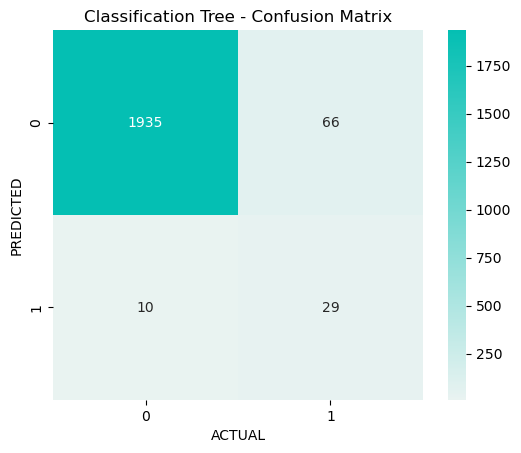

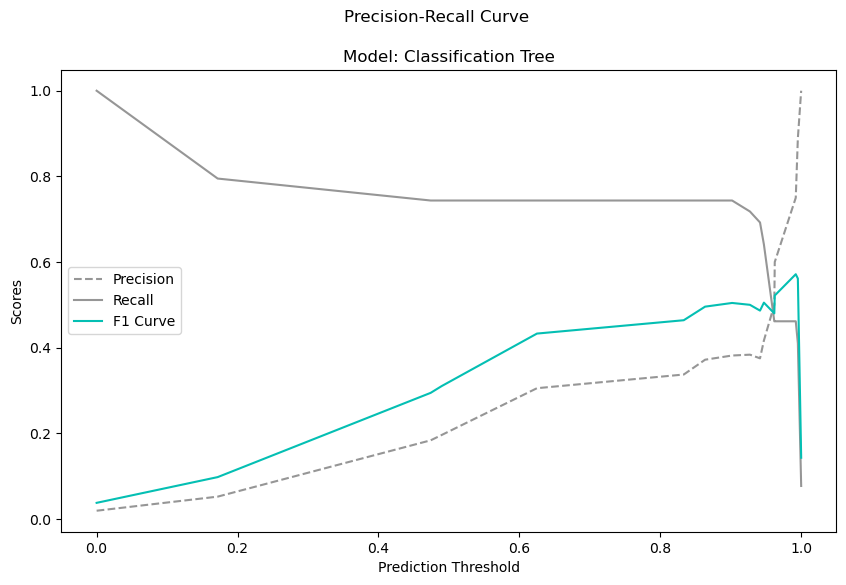

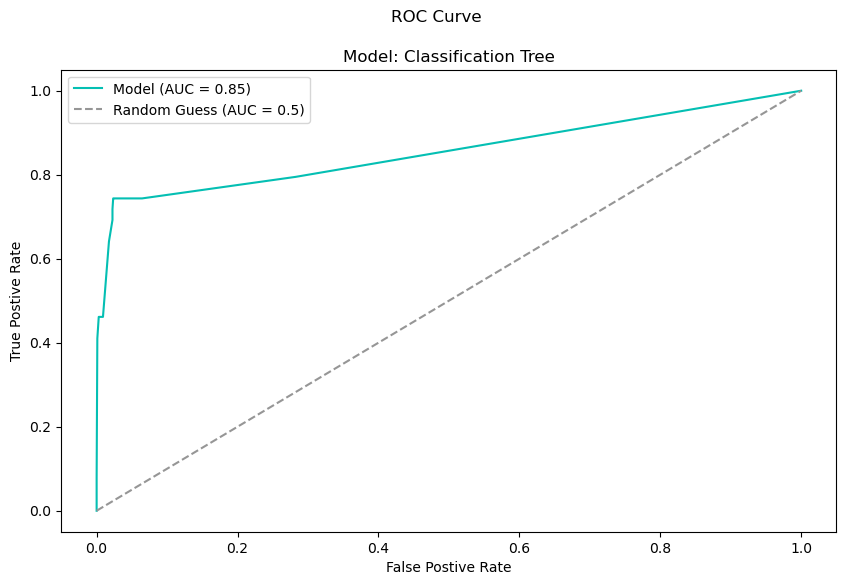

In [33]:
X_train_rs, X_test = scale_data(X_train_rs, X_test, False)

# Declare model
model_3 = DecisionTreeClassifier(max_depth=8)
model_3_name = 'Classification Tree'

# Fit model
model_3 = model_3.fit(X_train_rs, y_train_rs)

# Get predictions and probabilities
y_pred_3 = model_3.predict(X_test)
y_proba_3 = model_3.predict_proba(X_test)[:,1]

# Get model performance metrics
metrics_3, pr_curve_3, roc_param_3 = model_performance_metrics(y_test, y_proba_3, y_pred_3, model_3_name)

# Display model's main metrics
display(pd.DataFrame([metrics_3]))

# Compute and display confusion matrix
model_3_cm = confusion_matrix(y_test, y_pred_3)
show_confusion_matrix(model_3_cm, f'{model_3_name} - Confusion Matrix')

# Plot Precision-Recall Curve
plot_prcurve(pr_curve_3, model_3_name)

# ROC Curve
plot_roc_curve(roc_param_3, metrics_3, model_3_name)


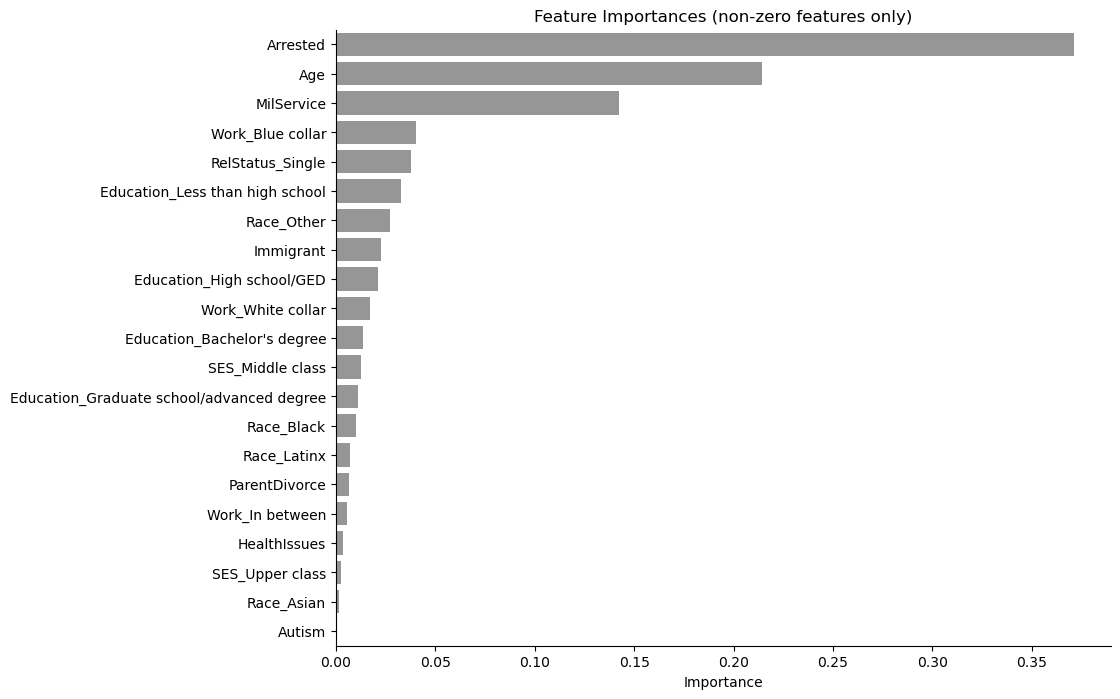

In [34]:
plot_feature_importances(model_3, X_3.columns)

In [35]:
metrics_overview = pd.DataFrame([metrics_1, metrics_2, metrics_3])

# Rename models for clarity
metrics_overview.loc[0, 'model'] = 'Class. Tree (all features)'
metrics_overview.loc[1, 'model'] = 'Class. Tree (limited features)'
metrics_overview.loc[2, 'model'] = 'Class. Tree (lim. feat. + upsampling)'

metrics_overview

,model,accuracy,precision,recall,f1_score,auc_score
0,Class. Tree (all features),99.117647,78.378378,74.358974,76.315789,95.887313
1,Class. Tree (limited features),98.872549,78.571429,56.410256,65.671642,87.275593
2,Class. Tree (lim. feat. + upsampling),96.274510,30.526316,74.358974,43.283582,85.474570


### SMOTE

In [36]:
# Remove categrories that are unique to the shooter dataset and not present in the general population dataset
X_4 = X.drop(columns=['Work_Unknown', 'SES_Unknown', 'Education_Unknown', 'Male'])
X_train, X_test, y_train, y_test = train_test_split(X_4,y,random_state=1,stratify=y, test_size=0.2)

n_pos = np.sum(y_train == 1)
n_neg = np.sum(y_train == 0)

# Create Nx as many positive samples
N = 50
ratio = {1: n_pos*N, 0: n_neg}

# Randomly oversample
ROS = OS.SMOTE(
	sampling_strategy = ratio,
	random_state = 42
)

X_train_rs, y_train_rs = ROS.fit_resample(X_train, y_train)

print(f"Original Pos Class Count: {np.sum(y_train)}")
print(f"Oversample Pos Class Count: {np.sum(y_train_rs)}")

Original Pos Class Count: 158
Oversample Pos Class Count: 7900


In [37]:
print('Prevalence (Class 1)')
print(f"In train set: {100*y_train_rs.mean():.2f}%")
print(f"In test set: {100*y_test.mean():.2f}%")

Prevalence (Class 1)
In train set: 49.69%
In test set: 1.91%


,model,accuracy,precision,recall,f1_score,auc_score
0,Class. Tree (SMOTE),98.431373,57.142857,71.794872,63.636364,85.618729


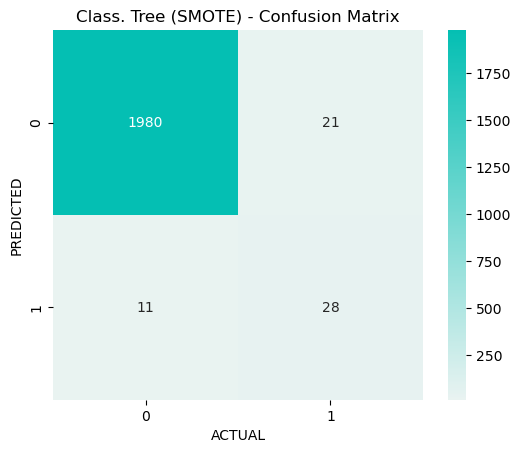

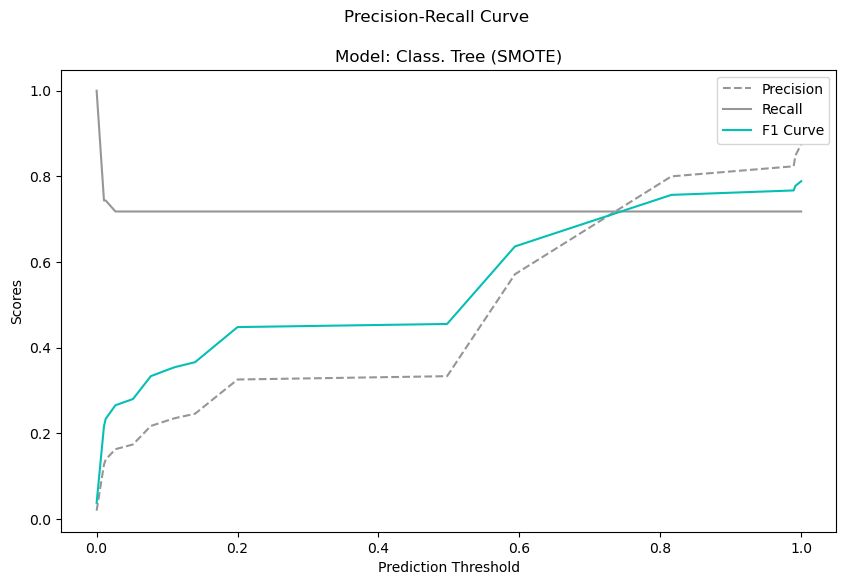

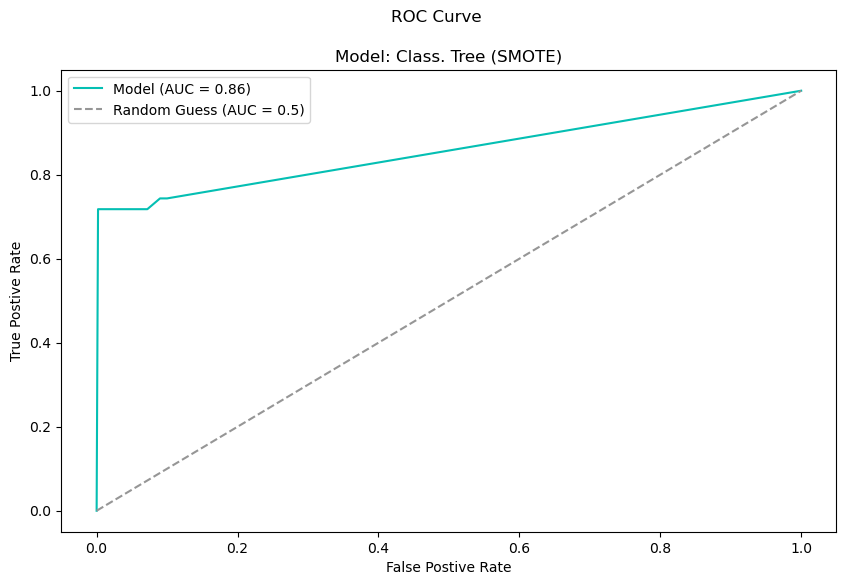

In [38]:
X_train_rs, X_test = scale_data(X_train_rs, X_test, False)

# Declare model
model_4 = DecisionTreeClassifier(max_depth=8)
model_4_name = 'Class. Tree (SMOTE)'

## ============== AUTOMATE THIS ================ ##

# Fit model
model_4 = model_4.fit(X_train_rs, y_train_rs)

# Get predictions and probabilities
y_pred_4 = model_4.predict(X_test)
y_proba_4 = model_4.predict_proba(X_test)[:,1]

# Get model performance metrics
metrics_4, pr_curve_4, roc_param_4 = model_performance_metrics(y_test, y_proba_4, y_pred_4, model_4_name)

# Display model's main metrics
display(pd.DataFrame([metrics_4]))

# Compute and display confusion matrix
model_4_cm = confusion_matrix(y_test, y_pred_4)
show_confusion_matrix(model_4_cm, f'{model_4_name} - Confusion Matrix')

# Plot Precision-Recall Curve
plot_prcurve(pr_curve_4, model_4_name)

# ROC Curve
plot_roc_curve(roc_param_4, metrics_4, model_4_name)


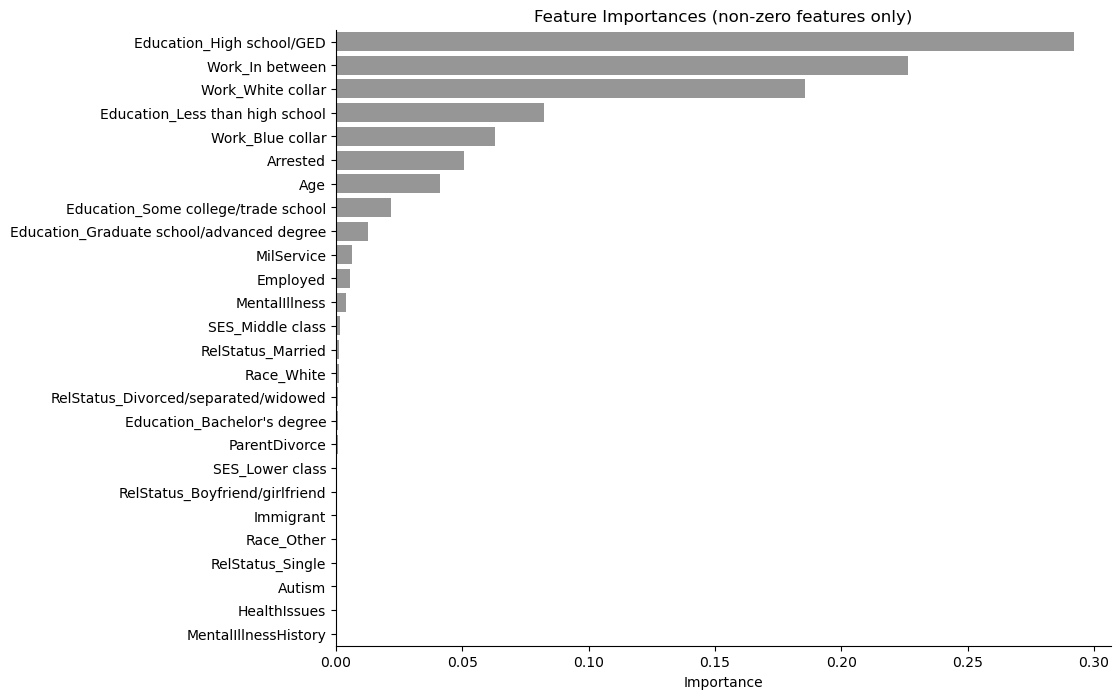

In [39]:
plot_feature_importances(model_4, X_4.columns)

## Summary

### Models performance
The performance of the 4 preliminary models tested here is shown in the DataFrame below.

In [40]:
metrics_overview = pd.DataFrame([metrics_1, metrics_2, metrics_3, metrics_4])

# Rename models for clarity
metrics_overview.loc[0, 'model'] = 'Classification Tree (all features)'
metrics_overview.loc[1, 'model'] = 'Class. Tree (limited features)'
metrics_overview.loc[2, 'model'] = 'Class. Tree (lim. feat. + upsampling)'
metrics_overview.loc[3, 'model'] = 'Class. Tree (lim. feat. + SMOTE)'

display(metrics_overview)

,model,accuracy,precision,recall,f1_score,auc_score
0,Classification Tree (all features),99.117647,78.378378,74.358974,76.315789,95.887313
1,Class. Tree (limited features),98.872549,78.571429,56.410256,65.671642,87.275593
2,Class. Tree (lim. feat. + upsampling),96.274510,30.526316,74.358974,43.283582,85.474570
3,Class. Tree (lim. feat. + SMOTE),98.431373,57.142857,71.794872,63.636364,85.618729


### Takeaways
At this stage, we have learned several important points:
1. Our first model "cheated" by using categories that were unique to the shooters data, such as unknown socio-economic status (SES) and employment type. We exclude these categories from the features set to avoid taking advantages of missing values without understanding any deeper mechanisms that could be at play.
2. By limiting the features available, the model performance has dropped but we believe we now represent the system in a more realistic way.
3. In our third model, we tackled the strong imbalance in the data by using random oversampling. This method simply duplicates Class 1 rows at random in the training set to balance the classes. This resulted in a severe drop in precision (higher false positive ratio) but an improvement of recall (lower false negative ratio). This goes in the right direction for this type of classification as the cost of a false negative (possible shooter identified as safe, resulting in potential casualties) is higher than that of a false positive (safe individual identified as risky, resulting in budget and time spent on additional checks). However, improving the precision would be a benefit if it can be achieved.
4. In our last model here, we used SMOTE instead of random oversampling to balance the dataset. Introducing synthetic data point instead of copying exisitng ones, produce a certain level of noise in the training data that helped the model improve its precision without losing any point in recall.

The figure below shows the comparison in F1 score between using Random Oversampling and SMOTE. The latter overperforms the former across all thresholds.

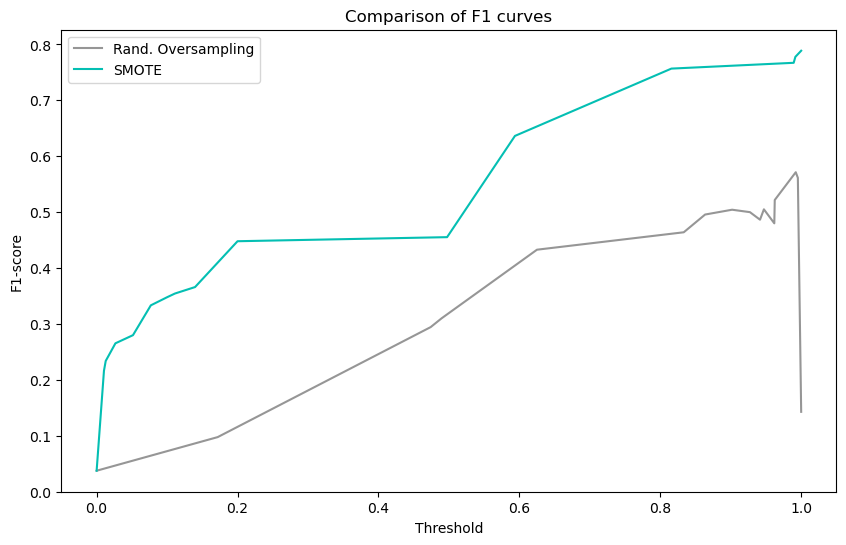

In [41]:
# F1-score comparison between Model 3 and Model 4
fig, ax = plt.subplots(figsize=default_figsize)
ax.plot(pr_curve_3['t_curve'], pr_curve_3['f1_curve'], c=main_color, label='Rand. Oversampling')
ax.plot(pr_curve_4['t_curve'], pr_curve_4['f1_curve'], c=highlight_color, label='SMOTE')
ax.legend()
ax.set_title('Comparison of F1 curves')
ax.set_xlabel('Threshold')
ax.set_ylabel('F1-score')
plt.show()

### Next steps
With the first iteration on the models done and valuable lessons learned about feature importance and balancing method, we can move to the next steps which will include:
1. Model selection, by trying other models and seeing their impact on the performance.
2. Hyperparameters optimisation, to further improve the performance of the models

In [66]:
# Save features and target for next steps
X = X_4.reset_index(drop=True)
y = y.reset_index(drop=True)

features_target = {
    'X': X,
    'y': y
}

with open('feat_target.bin','wb') as f:
    pickle.dump(features_target,f)